In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv('data\Train.csv')

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Aduragbemi\AppData\Local\Temp\ipykernel_23428\1100633172.py:1: SyntaxWarning: invalid escape sequence '\T'
  train = pd.read_csv('data\Train.csv')


In [3]:
train.head(3)

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,54,Pea,Lentil,Transplanting,Flood,Groundwater,4,87,17,Rabi,POLYGON ((78.18143246076087 17.978884603571068...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,58,Pea,Lentil,Transplanting,Flood,Canal,5,94,15,Rabi,POLYGON ((78.17545177547453 17.981074445477304...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,91,Pea,Lentil,Transplanting,Flood,Canal,3,99,20,Rabi,POLYGON ((78.16914224770792 17.976212849967755...


In [4]:
test = pd.read_csv('data\Test.csv')

<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Aduragbemi\AppData\Local\Temp\ipykernel_23428\3210526593.py:1: SyntaxWarning: invalid escape sequence '\T'
  test = pd.read_csv('data\Test.csv')


In [5]:
test.head(3)

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry
0,85197,Paddy,Telangana,Medak,Nizampet,2023-11-12 0:00:00,2024-05-14 0:00:00,81,99,Lentil,Pea,Transplanting,Flood,Groundwater,5,81,19,Rabi,POLYGON ((78.54742059207287 18.062307326758276...
1,779677,Paddy,Telangana,Medak,Nizampet,2023-12-20 0:00:00,2024-05-28 0:00:00,91,63,Lentil,Pea,Transplanting,Flood,Canal,5,97,15,Rabi,"POLYGON ((78.54812514990353 18.06739449795583,..."
2,1331840,Paddy,Telangana,Medak,Nizampet,2023-11-29 0:00:00,2024-05-18 0:00:00,94,89,Pea,Lentil,Transplanting,Flood,Canal,5,88,15,Rabi,POLYGON ((78.56002792938853 18.079607077817514...


### **SET _FarmID_ AS THE INDEX**

In [6]:
train.set_index('FarmID', inplace=True)

In [7]:
test.set_index('FarmID', inplace=True)

### **CONVERT *SDate* AND *HDate* FEATURE TO DATETIME**

In [8]:
train['SDate'] = pd.to_datetime(train['SDate'])
train['HDate'] = pd.to_datetime(train['HDate']) 

print(train['SDate'].dtype)
print(train['HDate'].dtype)

datetime64[ns]
datetime64[ns]


In [9]:
test['SDate'] = pd.to_datetime(test['SDate'])
test['HDate'] = pd.to_datetime(test['HDate'])

print(test['SDate'].dtype)
print(test['HDate'].dtype)

datetime64[ns]
datetime64[ns]


### **EXTRACTING FEATURES FROM _geometry_**

In [10]:
train['geometry'] = train['geometry'].astype(str).apply(wkt.loads)  
train['Area'] = train['geometry'].apply(lambda x: x.area if x else None)
train['Perimeter'] = train['geometry'].apply(lambda x: x.length if x else None)   

# Calculate centroid
train['Centroid'] = train['geometry'].apply(lambda x: x.centroid if x else None)

# Optionally split centroid into latitude and longitude
train['Centroid_Lat'] = train['Centroid'].apply(lambda x: x.y if x else None)
train['Centroid_Lon'] = train['Centroid'].apply(lambda x: x.x if x else None)

train = train.drop(['geometry', 'Centroid'], axis=1)


In [11]:
test['geometry'] = test['geometry'].astype(str).apply(wkt.loads)  
test['Area'] = test['geometry'].apply(lambda x: x.area if x else None)
test['Perimeter'] = test['geometry'].apply(lambda x: x.length if x else None)   

# Calculate centroid
test['Centroid'] = test['geometry'].apply(lambda x: x.centroid if x else None)

# Optionally split centroid into latitude and longitude
test['Centroid_Lat'] = test['Centroid'].apply(lambda x: x.y if x else None)
test['Centroid_Lon'] = test['Centroid'].apply(lambda x: x.x if x else None)

test = test.drop(['geometry', 'Centroid'], axis=1)

### **EXTRACT *day*, *month* AND *week_of_month* FROM *SDate* AND *HDate***

In [12]:
from datetime import datetime

def week_of_month(dt):
    """Calculate the week of the month for a given datetime object."""
    first_day = dt.replace(day=1)
    dom = dt.day  # Day of the month
    adjusted_dom = dom + first_day.weekday()  # Adjust for the first week's weekday
    return (adjusted_dom - 1) // 7 + 1

In [13]:
train['SDay'] = train['SDate'].dt.day
train['SMonth'] = train['SDate'].dt.month
train['SWOM'] = train['SDate'].apply(week_of_month)
train['SYear'] = train['SDate'].dt.year

train = train.drop(['SDate'], axis=1)

train['HDay'] = train['HDate'].dt.day
train['HMonth'] = train['HDate'].dt.month
train['HWOM'] = train['HDate'].apply(week_of_month)
train['HYear'] = train['HDate'].dt.year

train = train.drop(['HDate'], axis=1)

train.head(3)

,category,Crop,State,District,Sub-District,CropCoveredArea,CHeight,CNext,CLast,CTransp,...,Centroid_Lat,Centroid_Lon,SDay,SMonth,SWOM,SYear,HDay,HMonth,HWOM,HYear
FarmID,,,,,,,,,,,,,,,,,,,,,
1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,97,54,Pea,Lentil,Transplanting,...,17.978863,78.181592,25,11,4,2023,14,4,2,2024
1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,82,58,Pea,Lentil,Transplanting,...,17.980966,78.175606,13,11,3,2023,26,4,4,2024
1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,92,91,Pea,Lentil,Transplanting,...,17.976084,78.169207,19,12,4,2023,28,4,4,2024


In [14]:
test['SDay'] = test['SDate'].dt.day
test['SMonth'] = test['SDate'].dt.month
test['SWOM'] = test['SDate'].apply(week_of_month)
test['SYear'] = test['SDate'].dt.year

test = test.drop(['SDate'], axis=1)

test['HDay'] = test['HDate'].dt.day
test['HMonth'] = test['HDate'].dt.month
test['HWOM'] = test['HDate'].apply(week_of_month)
test['HYear'] = test['HDate'].dt.year

test = test.drop(['HDate'], axis=1)

test.head(3)

,Crop,State,District,Sub-District,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,...,Centroid_Lat,Centroid_Lon,SDay,SMonth,SWOM,SYear,HDay,HMonth,HWOM,HYear
FarmID,,,,,,,,,,,,,,,,,,,,,
85197,Paddy,Telangana,Medak,Nizampet,81,99,Lentil,Pea,Transplanting,Flood,...,18.062054,78.547474,12,11,2,2023,14,5,3,2024
779677,Paddy,Telangana,Medak,Nizampet,91,63,Lentil,Pea,Transplanting,Flood,...,18.067696,78.548407,20,12,4,2023,28,5,5,2024
1331840,Paddy,Telangana,Medak,Nizampet,94,89,Pea,Lentil,Transplanting,Flood,...,18.079480,78.560171,29,11,5,2023,18,5,3,2024


### **DROP *State* FEATURE**

In [15]:
train = train.drop(['State'], axis=1)
test = test.drop(['State'], axis=1)

In [16]:
train[['Area', 'Perimeter']].iloc[0]

Area         3.982611e-08
Perimeter    8.487694e-04
Name: 1326576, dtype: float64

### **SCALE _Area_ AND _Perimeter_**

In [17]:
train['Area'] = train['Area'] * 20000000
train['Perimeter'] = train['Perimeter'] * 2000000

In [18]:
test['Area'] = test['Area'] * 20000000
test['Perimeter'] = test['Perimeter'] * 2000000

### **CHANGE DATA TYPE OF NON-NUMERIC FEATURE TO _Category_**

In [19]:
train_cat_cols = train.select_dtypes(include='object').columns

for col in train_cat_cols:
    train[col] = train[col].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7888 entries, 1326576 to 1330504
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   category         7888 non-null   category
 1   Crop             7888 non-null   category
 2   District         7888 non-null   category
 3   Sub-District     7888 non-null   category
 4   CropCoveredArea  7888 non-null   int64   
 5   CHeight          7888 non-null   int64   
 6   CNext            7888 non-null   category
 7   CLast            7888 non-null   category
 8   CTransp          7888 non-null   category
 9   IrriType         7888 non-null   category
 10  IrriSource       7888 non-null   category
 11  IrriCount        7888 non-null   int64   
 12  WaterCov         7888 non-null   int64   
 13  ExpYield         7888 non-null   int64   
 14  Season           7888 non-null   category
 15  Area             7888 non-null   float64 
 16  Perimeter        7888 non-null   float

In [20]:
test_cat_cols = test.select_dtypes(include='object').columns

for col in test_cat_cols:
    test[col] = test[col].astype('category')

test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2718 entries, 85197 to 1326552
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Crop             2718 non-null   category
 1   District         2718 non-null   category
 2   Sub-District     2718 non-null   category
 3   CropCoveredArea  2718 non-null   int64   
 4   CHeight          2718 non-null   int64   
 5   CNext            2718 non-null   category
 6   CLast            2718 non-null   category
 7   CTransp          2718 non-null   category
 8   IrriType         2718 non-null   category
 9   IrriSource       2718 non-null   category
 10  IrriCount        2718 non-null   int64   
 11  WaterCov         2718 non-null   int64   
 12  ExpYield         2718 non-null   int64   
 13  Season           2718 non-null   category
 14  Area             2718 non-null   float64 
 15  Perimeter        2718 non-null   float64 
 16  Centroid_Lat     2718 non-null   float64

### **ENCODE _Categorical_ FEATURES**

In [21]:
for col in train_cat_cols:
    train[col] = train[col].cat.codes

train.head(3)

,category,Crop,District,Sub-District,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,...,Centroid_Lat,Centroid_Lon,SDay,SMonth,SWOM,SYear,HDay,HMonth,HWOM,HYear
FarmID,,,,,,,,,,,,,,,,,,,,,
1326576,1,5,5,61,97,54,4,0,3,1,...,17.978863,78.181592,25,11,4,2023,14,4,2,2024
1326577,1,5,5,61,82,58,4,0,3,1,...,17.980966,78.175606,13,11,3,2023,26,4,4,2024
1326578,1,5,5,61,92,91,4,0,3,1,...,17.976084,78.169207,19,12,4,2023,28,4,4,2024


In [22]:
for col in test_cat_cols:
    test[col] = test[col].cat.codes

test.head(3)

,Crop,District,Sub-District,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,...,Centroid_Lat,Centroid_Lon,SDay,SMonth,SWOM,SYear,HDay,HMonth,HWOM,HYear
FarmID,,,,,,,,,,,,,,,,,,,,,
85197,5,5,25,81,99,0,4,3,1,1,...,18.062054,78.547474,12,11,2,2023,14,5,3,2024
779677,5,5,25,91,63,0,4,3,1,0,...,18.067696,78.548407,20,12,4,2023,28,5,5,2024
1331840,5,5,25,94,89,4,0,3,1,0,...,18.079480,78.560171,29,11,5,2023,18,5,3,2024


### **MODEL BUILDING**

In [23]:
X = train.drop(['category'], axis=1)
y = train['category']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Oversampling the minority class
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

### **SCALING**

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **BUILDING WITH XGBOOST**

In [27]:
model = xgb.XGBClassifier(objective='multi:softmax', 
                          booster='gbtree',
                          num_class=4, 
                          enable_categorical=True, 
                          n_estimators=500,
                          random_state=42)

In [28]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [29]:
y_pred = model.predict(X_test)

In [30]:
f1_score(y_test, y_pred, average='weighted')

0.7417275279948529

### **BUILDING WITH CATBOOST**

In [31]:
from catboost import CatBoostClassifier

In [32]:
train['category'].value_counts()

category
1    6506
2     485
0     474
3     423
Name: count, dtype: int64

In [127]:
catmodel = CatBoostClassifier(iterations=500, 
                              learning_rate=0.3, 
                              #depth=6, 
                              loss_function='MultiClass', 
                              random_state=42, 
                              class_weights=[1, 4, 4, 4],
                              #num_trees=10,
                              max_depth=10)

In [128]:
catmodel.fit(X_train, y_train)

0:	learn: 1.2744695	total: 455ms	remaining: 3m 46s
1:	learn: 1.1845825	total: 743ms	remaining: 3m 5s
2:	learn: 1.1110124	total: 978ms	remaining: 2m 41s
3:	learn: 1.0600619	total: 1.25s	remaining: 2m 35s
4:	learn: 1.0136443	total: 1.48s	remaining: 2m 26s
5:	learn: 0.9770849	total: 1.69s	remaining: 2m 19s
6:	learn: 0.9357273	total: 1.93s	remaining: 2m 15s
7:	learn: 0.9036824	total: 2.16s	remaining: 2m 12s
8:	learn: 0.8746592	total: 2.36s	remaining: 2m 8s
9:	learn: 0.8401010	total: 2.6s	remaining: 2m 7s
10:	learn: 0.8120873	total: 2.82s	remaining: 2m 5s
11:	learn: 0.7895063	total: 3.08s	remaining: 2m 5s
12:	learn: 0.7632721	total: 3.32s	remaining: 2m 4s
13:	learn: 0.7310796	total: 3.51s	remaining: 2m 1s
14:	learn: 0.7087819	total: 3.69s	remaining: 1m 59s
15:	learn: 0.6900200	total: 3.93s	remaining: 1m 58s
16:	learn: 0.6712672	total: 4.14s	remaining: 1m 57s
17:	learn: 0.6579478	total: 4.42s	remaining: 1m 58s
18:	learn: 0.6426292	total: 4.6s	remaining: 1m 56s
19:	learn: 0.6347785	total: 4.8

In [129]:
catpred = catmodel.predict(X_test) 

In [130]:
f1_score(y_test, catpred, average='weighted')

0.7452790428585813

### **USING LIGHTGBM**

In [37]:
import lightgbm as lgb

In [109]:
light_model = lgb.LGBMClassifier(objective='multiclass', 
                                 random_state=42, 
                                 n_estimators=500,
                                 learning_rate=0.3)
light_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1721
[LightGBM] [Info] Number of data points in the train set: 18172, number of used features: 26
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294


LGBMClassifier(learning_rate=0.3, n_estimators=500, objective='multiclass',
               random_state=42)

In [110]:
light_pred = light_model.predict(X_test)

In [111]:
f1_score(y_test, light_pred, average='weighted')

0.7486159200759641

### **USING RANDOMFORESTCLASSIFIER**

In [41]:
clf = RandomForestClassifier(n_estimators=500, 
                             class_weight='balanced', 
                             random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42)

In [42]:
clf_pred = clf.predict(X_test)

In [43]:
f1_score(y_test, clf_pred, average='weighted')

0.7439324798804751

### **PREDICTION ON TEST SET**

In [44]:
test_pred = light_model.predict(test)
test_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int8)

In [45]:
submission = pd.DataFrame(
    {
        'ID': test.index,
        'Target': test_pred
    }
)

In [46]:
category_map = {0: 'Diseased', 1: 'Healthy', 2: 'Pests', 3: 'Stressed'}

submission['Target'] = submission['Target'].map(category_map)
submission.head(3)

,ID,Target
0,85197,Healthy
1,779677,Healthy
2,1331840,Healthy


In [47]:
submission.to_csv('submission2.csv', index=False)

### **FEATURE IMPORTANCE**

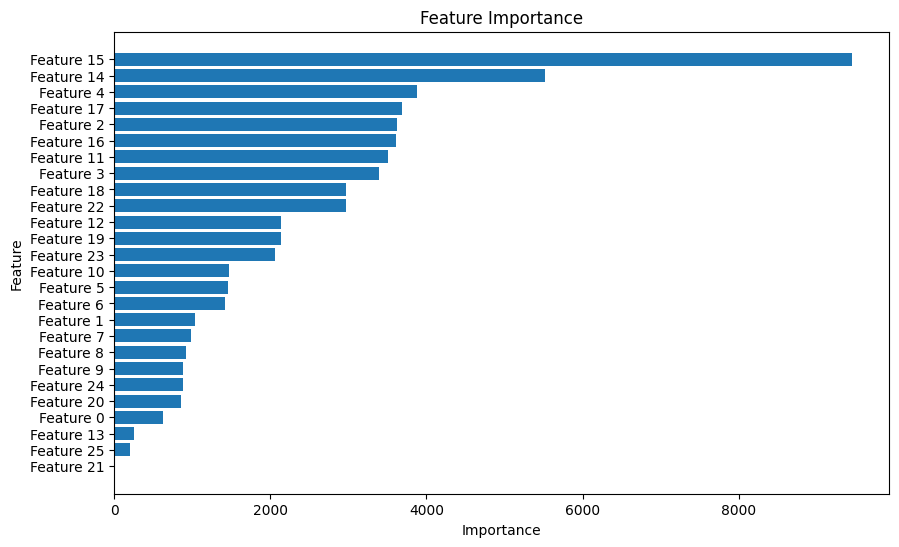

In [112]:
# Check feature importance
feature_importances = light_model.feature_importances_
feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [118]:
from sklearn.decomposition import PCA

In [119]:
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [120]:
clf_pca = RandomForestClassifier(n_estimators=500, random_state=42)
clf_pca.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [121]:
clf_pca_pred = clf_pca.predict(X_test_pca)

In [122]:
f1_score(y_test, clf_pca_pred, average='weighted')

0.7031912883518486